# Wingbeat analysis
This notebook demonstrates how to analyse wingbeat data output from camfi.

First, load the required libraries.

In [1]:
import math

from bces import bces
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
from numpy.random import default_rng
from scipy.stats import norm
from sklearn.mixture import GaussianMixture



Next, load the wingbeat frequency data. It is in a tab-separated format with the following columns:

1. `image_name` : relative path to image
2. `capture_time` : datetime in yyyy-mm-dd HH:MM:SS format
3. `annotation_idx` : index of annotation in image (arbitrary)
4. `best_peak` : period of wingbeat in pixels
5. `blur_length` : length of motion blur in pixels
6. `snr` : signal to noise ratio of best peak
7. `wb_freq_up` : wingbeat frequency estimate, assuming upward motion (and zero body-length)
8. `wb_freq_down` : wingbeat frequency estimate, assuming downward motion (and zero body-length)
9. `et_up` : corrected moth exposure time, assuming upward motion
10. `et_dn` : corrected moth exposure time, assuming downward motion
11. `period_up` : wingbeat period, assuming upward motion (and zero body-length)
12. `period_dn` : wingbeat period, assuming downward motion (and zero body-length)
13. `spec_dens` : comma separated values, with the spectral density array associated with the annotation

For the purposes of this notebook, we are particularly interested in wingbeat frequency, so we will only load the relevant columns. For other analyses you may want to load additional columns such as `capture_time` etc.

In [2]:
data_path = "data/cabramurra_wingbeats.csv.bz2"

data = np.loadtxt(
    data_path,
    dtype=[
        ('best_peak', 'u2'),
        ('blur_length', 'u2'),
        ('snr', 'f8'),
        ('wb_freq_up', 'f8'),
        ('wb_freq_dn', 'f8'),
        ('et_up', 'f8'),
        ('et_dn', 'f8')
    ],
    usecols=(3, 4, 5, 6, 7, 8, 9),
    delimiter='\t',
    skiprows=1,
)

Next we want to filter the data by SNR.

In [3]:
snr_thresh = 4.0

Visualising the data, with the SNR threshold indicated:

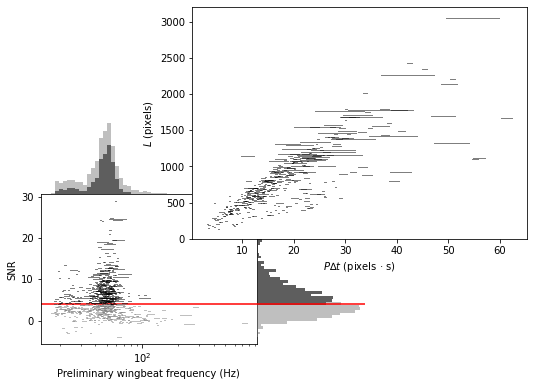

In [4]:
filtered_data = data[data['snr'] >= snr_thresh]

# Setting up the figure with multiple subfigures
left, width = 0.1, 0.4
bottom, height = 0.1, 0.4
hist_height = 0.2
spacing = 0
spacing_regression = -0.12

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, hist_height]
rect_histy = [left + width + spacing, bottom, hist_height, height]
rect_regression = [
    left + width + spacing_regression,
    bottom + height + spacing_regression,
    1. - left - width - spacing_regression,
    1. - bottom - height - spacing_regression,
]

fig = plt.figure(
    figsize=(7.5, 5.2),
    #dpi=1000.0,
)

# Plotting preliminary wingbeat frequency data with marginal distributions
ax = fig.add_axes(
    rect_scatter,
    xlabel="Preliminary wingbeat frequency (Hz)",
    ylabel="SNR",
    xscale="log",
)
# Plot above-threshold data
ax.plot(
    np.stack((
        data['wb_freq_dn'][data['snr'] >= snr_thresh],
        data['wb_freq_up'][data['snr'] >= snr_thresh],
    )),
    np.broadcast_to(
        data['snr'][data['snr'] >= snr_thresh],
        (2,) + data[data['snr'] >= snr_thresh].shape,
    ),
    c="k",
    alpha=0.5,
    lw=1,
)
# Plot below-threshold data
ax.plot(
    np.stack((
        data['wb_freq_dn'][data['snr'] < snr_thresh],
        data['wb_freq_up'][data['snr'] < snr_thresh],
    )),
    np.broadcast_to(
        data['snr'][data['snr'] < snr_thresh],
        (2,) + data[data['snr'] < snr_thresh].shape,
    ),
    c="grey",
    alpha=0.5,
    lw=1,
)
    
ax.axhline(snr_thresh, c="r", zorder=0, label="SNR Threshold")

# Plotting marginals
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

# no labels
ax_histx.axis("off")
ax_histy.axis("off")


hx, bx, p = ax_histx.hist(
    np.concatenate([
        data['wb_freq_dn'],
        data['wb_freq_up']
    ]),
    bins=np.logspace(
        np.log10(min(data['wb_freq_dn'])),
        np.log10(max(data['wb_freq_up']))
    ),
    facecolor="grey",
    alpha=0.5,
)

hx_filt, bx_filt, p = ax_histx.hist(
    np.concatenate([
        filtered_data['wb_freq_dn'],
        filtered_data['wb_freq_up']
    ]),
    bins=bx,
    facecolor="k",
    alpha=0.5,
)

hy, by, p = ax_histy.hist(
    data['snr'],
    bins=50,
    orientation='horizontal',
    facecolor="grey",
    alpha=0.5,
)

ax_histy.hist(
    filtered_data['snr'],
    bins=by,
    orientation='horizontal',
    facecolor="k",
    alpha=0.5,
)

# SNR threshold line should be continued into the marginal
ax_histy.axhline(snr_thresh, c="r", zorder=1, label="SNR Threshold")

# Plotting blur length vs. pixel-period * ∆t for filtered data only
ax_regression = fig.add_axes(
    rect_regression,
    ylabel="$L$ (pixels)",
    xlabel="$P∆t$ (pixels · s)",
)

p = ax_regression.plot(
    np.stack((
        filtered_data["best_peak"] * filtered_data["et_up"],
        filtered_data["best_peak"] * filtered_data["et_dn"],
    )),
    np.broadcast_to(
        filtered_data["blur_length"],
        (2,) + filtered_data.shape,
    ),
    c="k",
    alpha=0.5,
    lw=1,
)

Based on the above plots, we now wish to select a number of target classes. This will be used for fitting a Gaussian mixture-model to the preliminary winbeat frequencies (which assume zero bodylength), and for classification in the linear regression step for the unbiased estimate of wingbeat frequency.

In [5]:
n_classes = 2

Fitting the Gaussian mixture-model to the preliminary wingbeat data:

In [6]:
gmm = GaussianMixture(n_components=n_classes, random_state=20200721)
labels = gmm.fit_predict(
    np.log10(np.concatenate([
        filtered_data['wb_freq_dn'],
        filtered_data['wb_freq_up']
    ])).reshape(-1, 1))

print("converged:", gmm.converged_)

labels = labels[:filtered_data.shape[0]] + labels[filtered_data.shape[0]:]

converged: True


Now we use an EM algorithm to classify the data using BCES regressions of $L$ vs. $P \Delta t$. Here we will plot the result of the regression under the initial randomisation as well as after the final EM iteration


--- Iteration 0, Regression 0
prob_class:, 0.467687074829932
Wingbeat frequency: 37.063683080358814 +/- 3.5250747416266788 Hz
Body length: 127.85101522566015 +/- 47.81817737917329 px
Covariance: -165.34240492286315

--- Iteration 0, Regression 1
prob_class:, 0.532312925170068
Wingbeat frequency: 39.80546342745053 +/- 2.755691942102085 Hz
Body length: 91.65510681931562 +/- 37.57809201311573 px
Covariance: -100.27083282528011
stopped after iteration 11

--- Iteration 11, Regression 0
prob_class:, 0.1326530612244898
n_class_members:, 78
Wingbeat frequency: 23.466053959690015 +/- 1.556810066609258 Hz
Body length: 18.48362816432251 +/- 26.19545270649577 px
Covariance: -39.134953347059586

--- Iteration 11, Regression 1
prob_class:, 0.8673469387755102
n_class_members:, 510
Wingbeat frequency: 47.216324294653226 +/- 1.3084396195710057 Hz
Body length: 36.269535893196235 +/- 17.388466508134254 px
Covariance: -21.960631386433548


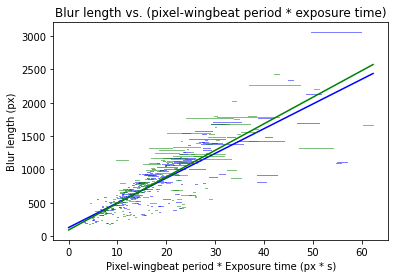

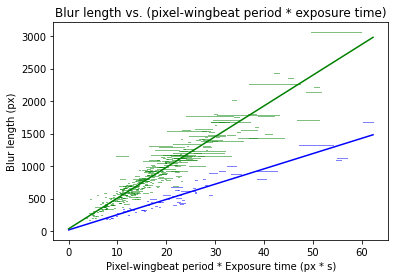

In [7]:
rng = default_rng(20201008)

# E-step
class_mask = rng.integers(0, n_classes, len(filtered_data), "u1")
prob_class = np.array([np.mean(class_mask == i) for i in range(n_classes)])
n_class_members = np.array([np.count_nonzero(class_mask == i) for i in range(n_classes)])
tiled_class_mask = np.tile(class_mask, 2)

def bces_em(data, class_mask, prob_class, n_classes):
    xerr = data["best_peak"] * (data["et_dn"] - data["et_up"]) / 2
    yerr = np.zeros_like(xerr)
    x = data["best_peak"] * data["et_up"] + xerr
    y = data["blur_length"]
    cov = np.zeros_like(x)
    
    estimates = []
    err = np.zeros((n_classes, len(data)))
    for class_id in range(n_classes):
        mask = class_mask == class_id
        wf_estimate, bl_estimate, wf_err, bl_err, cov_wf_bl = (
            e[0] for e in bces.bces(x[mask], xerr[mask], y[mask], yerr[mask], cov[mask])
        )
        estimates.append((wf_estimate, bl_estimate, wf_err, bl_err, cov_wf_bl))
        
        err[class_id, :] = (bl_estimate + wf_estimate * x - y) ** 2 / prob_class[class_id]
        
    return estimates, err


def plot_multiple_regression(data, class_mask, estimates):
    cmap = np.array(["b", "g", "r", "k"])
    fig = plt.figure()
    ax = fig.add_subplot(
        111,
        title="Blur length vs. (pixel-wingbeat period * exposure time)",
        ylabel="Blur length (px)",
        xlabel="Pixel-wingbeat period * Exposure time (px * s)",
    )

    for i in range(len(estimates)):
        # Plot data
        ax.plot(
            np.stack((
                (data["best_peak"] * data["et_up"])[class_mask == i],
                (data["best_peak"] * data["et_dn"])[class_mask == i],
            )),
            np.broadcast_to(
                data["blur_length"][class_mask == i],
                (2,) + data[class_mask == i].shape,
            ),
            c=cmap[i],
            alpha=0.5,
            lw=1,
        )
           
        # Plot regression line
        wf_estimate, bl_estimate, wf_err, bl_err, cov_wf_bl = estimates[i]
        ax.plot(
            [0, max(data["best_peak"] * data["et_dn"])],
            [bl_estimate, wf_estimate * max(data["best_peak"] * data["et_dn"]) + bl_estimate],
            c=cmap[i]
        )


for i in range(50):
    estimates, err = bces_em(filtered_data, class_mask, prob_class, n_classes)
    if i == 0:
        plot_multiple_regression(filtered_data, class_mask, estimates)
    class_mask_temp = np.argmin(err, axis=0)
    if (class_mask == class_mask_temp).all():
        print(f"stopped after iteration {i}")
        break
    
    if i == 0:
        j = 0
        for wf_estimate, bl_estimate, wf_err, bl_err, cov_wf_bl in estimates:
            print(f"\n--- Iteration {i}, Regression {j}")
            print(f"prob_class:, {prob_class[j]}")
            print(f"Wingbeat frequency: {wf_estimate} +/- {wf_err} Hz")
            print(f"Body length: {bl_estimate} +/- {bl_err} px")
            print(f"Covariance: {cov_wf_bl}")
            j += 1
    
    class_mask[:] = class_mask_temp
    prob_class = np.array([np.mean(class_mask == i) for i in range(n_classes)])
    n_class_members = np.array([np.count_nonzero(class_mask == i) for i in range(n_classes)])
        
plot_multiple_regression(filtered_data, class_mask, estimates)
j = 0
for wf_estimate, bl_estimate, wf_err, bl_err, cov_wf_bl in estimates:
    print(f"\n--- Iteration {i}, Regression {j}")
    print(f"prob_class:, {prob_class[j]}")
    print(f"n_class_members:, {n_class_members[j]}")
    print(f"Wingbeat frequency: {wf_estimate} +/- {wf_err} Hz")
    print(f"Body length: {bl_estimate} +/- {bl_err} px")
    print(f"Covariance: {cov_wf_bl}")
    j += 1

Finally, we reproduce the figure from the publication, which includes the GMM and EM classification

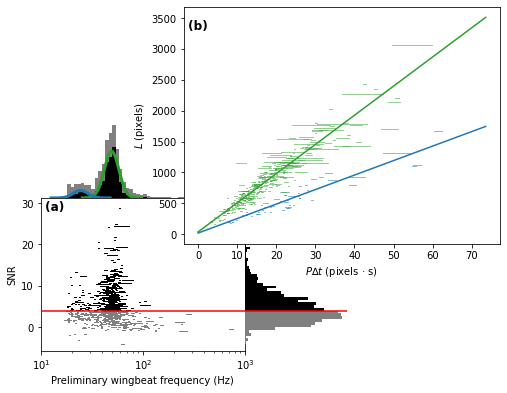

In [8]:
filtered_data = data[data['snr'] >= snr_thresh]

a_alpha = 1.
b_alpha = 0.5

# Setting up the figure with multiple subfigures
left, width = 0.1, 0.4
bottom, height = 0.1, 0.4
hist_height = 0.2
spacing = 0
spacing_regression = -0.12

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, hist_height]
rect_histy = [left + width + spacing, bottom, hist_height, height]
rect_regression = [
    left + width + spacing_regression,
    bottom + height + spacing_regression,
    1. - left - width - spacing_regression,
    1. - bottom - height - spacing_regression,
]

fig_width = 180  # mm
fig_width /= 25.4  # inches
fig_height = fig_width * 3 / 4

fig = plt.figure(
    figsize=(fig_width, fig_height),
)

# Plotting preliminary wingbeat frequency data with marginal distributions
ax = fig.add_axes(
    rect_scatter,
    xlabel="Preliminary wingbeat frequency (Hz)",
    ylabel="SNR",
    xscale="log",
    xlim=(10, 1000),
)

# Plot above-threshold data
ax.plot(
    np.stack((
        data['wb_freq_dn'][data['snr'] >= snr_thresh],
        data['wb_freq_up'][data['snr'] >= snr_thresh],
    )),
    np.broadcast_to(
        data['snr'][data['snr'] >= snr_thresh],
        (2,) + data[data['snr'] >= snr_thresh].shape,
    ),
    c="k",
    alpha=a_alpha,
    lw=1,
)
# Plot below-threshold data
ax.plot(
    np.stack((
        data['wb_freq_dn'][data['snr'] < snr_thresh],
        data['wb_freq_up'][data['snr'] < snr_thresh],
    )),
    np.broadcast_to(
        data['snr'][data['snr'] < snr_thresh],
        (2,) + data[data['snr'] < snr_thresh].shape,
    ),
    c="grey",
    alpha=a_alpha,
    lw=1,
)
    
ax.axhline(snr_thresh, c="r", zorder=10, label="SNR Threshold")

# Plotting marginals
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

# no labels
ax_histx.axis("off")
ax_histy.axis("off")


hx, bx, p = ax_histx.hist(
    np.concatenate([
        data['wb_freq_dn'],
        data['wb_freq_up']
    ]),
    bins=np.logspace(
        np.log10(min(data['wb_freq_dn'])),
        np.log10(max(data['wb_freq_up']))
    ),
    facecolor="grey",
    alpha=a_alpha,
)

hx_filt, bx_filt, p = ax_histx.hist(
    np.concatenate([
        filtered_data['wb_freq_dn'],
        filtered_data['wb_freq_up']
    ]),
    bins=bx,
    facecolor="k",
    alpha=a_alpha,
)

# Plotting GMM
scaling = np.mean(hx_filt * (bx_filt[1:] - bx_filt[:-1])) / 2

pdf_x0 = np.logspace(
    gmm.means_[0][0] - math.sqrt(gmm.covariances_[0][0]) * 4,
    gmm.means_[0][0] + math.sqrt(gmm.covariances_[0][0]) * 4,
    num=100,
)

ax_histx.plot(
    pdf_x0,
    scaling * gmm.weights_[0] * norm.pdf(np.log10(pdf_x0), loc=gmm.means_[0][0], scale=math.sqrt(gmm.covariances_[0][0])),
    c='tab:green',
    label="0",
    linewidth=3,
)

pdf_x1 = np.logspace(
    gmm.means_[1][0] - math.sqrt(gmm.covariances_[1][0]) * 4,
    gmm.means_[1][0] + math.sqrt(gmm.covariances_[1][0]) * 4,
    num=100,
)

ax_histx.plot(
    pdf_x1,
    scaling * gmm.weights_[1] * norm.pdf(np.log10(pdf_x1), loc=gmm.means_[1][0], scale=math.sqrt(gmm.covariances_[1][0])),
    c='tab:blue',
    label="2",
    linewidth=3,
)

# Plotting vertical marginal
# First need to pin bin edges to snr_thresh to avoid overlap
min_snr = data['snr'].min()
max_snr = data['snr'].max()
nbins = 50
by = np.linspace(
    min_snr - (max_snr - min_snr) / nbins,
    max_snr,
    num=nbins + 1,
)
by += snr_thresh - by[by <= snr_thresh][-1]

hy, by, p = ax_histy.hist(
    data['snr'],
    bins=by,
    orientation='horizontal',
    facecolor="grey",
    alpha=a_alpha,
)

ax_histy.hist(
    filtered_data['snr'],
    bins=by,
    orientation='horizontal',
    facecolor="k",
    alpha=a_alpha,
)

# SNR threshold line should be continued into the marginal
ax_histy.axhline(snr_thresh, c="r", zorder=1, label="SNR Threshold")

# Plotting blur length vs. pixel-period * ∆t for filtered data only
ax_regression = fig.add_axes(
    rect_regression,
    ylabel="$L$ (pixels)",
    xlabel="$P∆t$ (pixels · s)",
)

# Define colours for each class
cmap = np.array(["tab:blue", "tab:green", "r", "k"])
assert len(cmap) >= n_classes, "Need to define more colours"

for i in range(len(estimates)):
    # Plot the data
    ax_regression.plot(
        np.stack((
            (filtered_data["best_peak"] * filtered_data["et_up"])[class_mask == i],
            (filtered_data["best_peak"] * filtered_data["et_dn"])[class_mask == i],
        )),
        np.broadcast_to(
            filtered_data["blur_length"][class_mask == i],
            (2,) + filtered_data[class_mask == i].shape,
        ),
        c=cmap[i],
        alpha=b_alpha,
        lw=1,
    )
    
    # Plot the regression lines
    wf_estimate, bl_estimate, wf_err, bl_err, cov_wf_bl = estimates[i]
    ax_regression.plot(
        [0, max(data["best_peak"] * data["et_dn"])],
        [bl_estimate, wf_estimate * max(data["best_peak"] * data["et_dn"]) + bl_estimate],
        c=cmap[i]
    )
    
# Add titles
title_y = 0.88
a_title = ax.set_title(
    " (a)",
    fontdict={"fontweight": "bold"},
    loc="left",
    y=title_y
)
b_title = ax_regression.set_title(
    " (b)",
    fontdict={"fontweight": "bold"},
    loc="left",
    y=title_y
)

In [9]:
fig.savefig("wingbeat_frequency_figure.pdf", dpi=600.0, pad_inches=0.0)